In [0]:
#!pip install geopandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
import tensorflow as tf
import os
import re
import numpy as np
from string import punctuation
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D

In [6]:
url = 'https://www.mohfw.gov.in/'
web_content = requests.get(url).content
soup = BeautifulSoup(web_content, "html.parser")
extract_contents = lambda row: [x.text.replace('\n', '') for x in row]
stats = [] 
all_rows = soup.find_all('tr')
for row in all_rows:
    stat = extract_contents(row.find_all('td')) 
    if len(stat) == 5:
        stats.append(stat)
new_cols = ["Sr.No", "States/UT","Confirmed","Recovered","Deceased"]
state_data = pd.DataFrame(data = stats, columns = new_cols)
state_data.head()

,Sr.No,States/UT,Confirmed,Recovered,Deceased
0,1,Andaman and Nicobar Islands,33,11,0
1,2,Andhra Pradesh,1259,258,31
2,3,Arunachal Pradesh,1,1,0
3,4,Assam,38,27,1
4,5,Bihar,346,57,2


In [0]:
state_data['Confirmed'] = state_data['Confirmed'].map(int)
state_data['Recovered'] = state_data['Recovered'].map(int)
state_data['Deceased'] = state_data['Deceased'].map(int)

In [8]:
map_data = gpd.read_file('Indian_States.shp')
map_data.rename(columns = {'st_nm':'States/UT'}, inplace = True)
map_data.head()

,States/UT,geometry
0,Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."
2,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26..."
3,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24..."
4,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623..."


In [0]:
map_data['States/UT'] = map_data['States/UT'].str.replace('&','and')
map_data['States/UT'].replace('Arunanchal Pradesh',
                              'Arunachal Pradesh', inplace = True)
map_data['States/UT'].replace('Telangana', 
                              'Telengana', inplace = True)
map_data['States/UT'].replace('NCT of Delhi', 
                              'Delhi', inplace = True)
map_data['States/UT'].replace('Andaman and Nicobar Island', 
                              'Andaman and Nicobar Islands', 
                               inplace = True)

In [10]:
merged_data = pd.merge(map_data, state_data, 
                       how = 'left', on = 'States/UT')
merged_data.fillna(0, inplace = True)
merged_data.drop('Sr.No', axis = 1, inplace = True)
merged_data.head()

,States/UT,geometry,Confirmed,Recovered,Deceased
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",33.0,11.0,0.0
1,Arunachal Pradesh,"POLYGON ((96.16261 29.38078, 96.16860 29.37432...",1.0,1.0,0.0
2,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...",38.0,27.0,1.0
3,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...",346.0,57.0,2.0
4,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",40.0,17.0,0.0


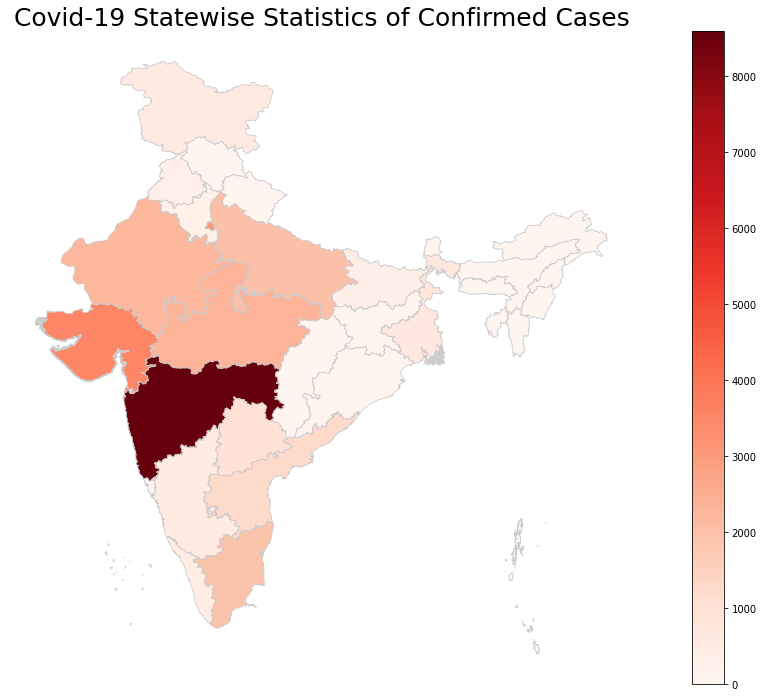

In [11]:
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Covid-19 Statewise Statistics of Confirmed Cases', 
             fontdict =  {'fontsize': '25', 'fontweight' : '3'})
merged_data.plot(column = 'Confirmed', cmap='Reds', 
                 linewidth=0.8, ax=ax, edgecolor='0.8', 
                 legend = True)
plt.show()

In [0]:
train = pd.read_csv('Covid_Train.csv')
test = pd.read_csv('Covid_Test.csv')
train_data = train.copy()
test_data = test.copy()

In [0]:
train_data = train_data.set_index('id', drop = True)

In [15]:
print(train_data.shape)
train_data.head()

(699, 9)


,created_at,text,user/id,user/name,user/location,user/url,lang,timestamp_ms,TARGET
id,,,,,,,,,
1.260000e+18,Tue Apr 28 12:14:59 +0000 2020,PAYPAL BS 166000x$ OPERACIONES HACIA VENEZUELA...,9.320000e+17,FamiEnvios,LatinoAmerica,http://www.famienvios.com,es,1.590000e+12,1.0
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,🇭🇷 Croatia has confirmed 8 new coronavirus cas...,1.250000e+18,Data Trackers,NaN,NaN,en,1.590000e+12,1.0
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,RT @AriMulano_: Due To #COVID19 I’ll Be Sendin...,8.780000e+17,Kane Settles,NaN,NaN,en,1.590000e+12,0.0
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,🍊La formación naranja hace propuestas construc...,2.369476e+09,Libre Diario Digital #QuedateEnCasa,"Tenerife, I.Canarias, España",http://www.librediariodigital.net/,es,1.590000e+12,0.0
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,Tut mir nur der Rücken weh oder sind das schon...,5.433539e+08,Helen Dalibor,Deutschland,http://helendalibor.wordpress.com,de,1.590000e+12,1.0


In [16]:
print(test_data.shape)
test_data.head()

(301, 9)


,created_at,id,text,user/id,user/name,user/location,user/url,lang,timestamp_ms
0,Tue Apr 28 12:15:15 +0000 2020,1.260000e+18,RT @C4Ciaran: It is now the case that more det...,1.190000e+18,Sarah Dee,U.K.,NaN,en,1.590000e+12
1,Tue Apr 28 12:15:15 +0000 2020,1.260000e+18,RT @TomFitton: Mayo Clinic to furlough or redu...,1.140000e+18,@roomato,Maryland hostage,NaN,en,1.590000e+12
2,Tue Apr 28 12:15:15 +0000 2020,1.260000e+18,@outertemple and my friends @CliffordLaw are p...,3.888329e+08,Gerard McDermott,NaN,http://www.mcdermottqc.com,en,1.590000e+12
3,Tue Apr 28 12:15:15 +0000 2020,1.260000e+18,Franges .@emergenciescat per sortir: 6 a 8h es...,1.415407e+08,Elena Garcia,NaN,NaN,ca,1.590000e+12
4,Tue Apr 28 12:15:15 +0000 2020,1.260000e+18,RT @OurCompass: Many scientists believe #COVID...,2.758327e+09,lipstick,"England, United Kingdom",NaN,en,1.590000e+12


In [17]:
train_data.isnull().sum()

created_at         4
text               4
user/id            4
user/name          4
user/location    212
user/url         423
lang               4
timestamp_ms       4
TARGET             4
dtype: int64

In [18]:
train_data[['text', 'user/id']] = train_data[['text', 'user/id']].fillna(value = 'Missing')
train_data = train_data.dropna()
train_data.isnull().sum()

created_at       0
text             0
user/id          0
user/name        0
user/location    0
user/url         0
lang             0
timestamp_ms     0
TARGET           0
dtype: int64

In [19]:
length = []
[length.append(len(str(text))) for text in train_data['text']]
train_data['length'] = length
train_data.head()

,created_at,text,user/id,user/name,user/location,user/url,lang,timestamp_ms,TARGET,length
id,,,,,,,,,,
1.260000e+18,Tue Apr 28 12:14:59 +0000 2020,PAYPAL BS 166000x$ OPERACIONES HACIA VENEZUELA...,9.32e+17,FamiEnvios,LatinoAmerica,http://www.famienvios.com,es,1.590000e+12,1.0,140
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,🍊La formación naranja hace propuestas construc...,2.36948e+09,Libre Diario Digital #QuedateEnCasa,"Tenerife, I.Canarias, España",http://www.librediariodigital.net/,es,1.590000e+12,0.0,115
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,Tut mir nur der Rücken weh oder sind das schon...,5.43354e+08,Helen Dalibor,Deutschland,http://helendalibor.wordpress.com,de,1.590000e+12,1.0,140
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,"On #WorkersMemorialDay, the Labor Movement rem...",4.30834e+08,"New York City Central Labor Council, AFL-CIO",NYC,http://www.nycclc.org,en,1.590000e+12,1.0,140
1.260000e+18,Tue Apr 28 12:15:00 +0000 2020,#Coronavirus: Festivalul Internaţional de Film...,1.19309e+08,AGERPRES,"Bucharest, Romania",http://www.agerpres.ro,ro,1.590000e+12,1.0,133


In [20]:
min(train_data['length']), max(train_data['length']), round(sum(train_data['length'])/len(train_data['length']))

(14, 144, 130)

In [0]:
max_features = 200

tokenizer = Tokenizer(num_words = max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts = train_data['text'])
X = tokenizer.texts_to_sequences(texts = train_data['text'])

In [0]:
X = pad_sequences(sequences = X, maxlen = max_features, padding = 'pre')

In [23]:
print(X.shape)
y = train_data['TARGET'].values
print(y.shape)

(245, 200)
(245,)


In [0]:
gru_model = Sequential(name = 'gru_nn_model')
gru_model.add(layer = Embedding(input_dim = max_features, output_dim = 120, name = '1st_layer'))
gru_model.add(layer = GRU(units = 120, dropout = 0.2, 
                          recurrent_dropout = 0.2, recurrent_activation = 'relu', 
                          activation = 'relu', name = '2nd_layer'))
gru_model.add(layer = Dropout(rate = 0.4, name = '3rd_layer'))
gru_model.add(layer = Dense(units = 120, activation = 'relu', name = '4th_layer'))
gru_model.add(layer = Dropout(rate = 0.2, name = '5th_layer'))
gru_model.add(layer = Dense(units = len(set(y)), activation = 'softmax', name = 'output_layer'))
gru_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [25]:
gru_model.summary()

Model: "gru_nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_layer (Embedding)        (None, None, 120)         24000     
_________________________________________________________________
2nd_layer (GRU)              (None, 120)               87120     
_________________________________________________________________
3rd_layer (Dropout)          (None, 120)               0         
_________________________________________________________________
4th_layer (Dense)            (None, 120)               14520     
_________________________________________________________________
5th_layer (Dropout)          (None, 120)               0         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 242       
Total params: 125,882
Trainable params: 125,882
Non-trainable params: 0
________________________________________________

In [26]:
gru_model_fit = gru_model.fit(X, y, epochs = 1)

8/8 [==============================] - 3s 431ms/step - loss: 0.6770 - accuracy: 0.7551


In [27]:
print(test.shape)
test_data = test.copy()
print(test_data.shape)

(301, 9)
(301, 9)


In [28]:
test_data = test_data.set_index('id', drop = True)
test_data.shape

(301, 8)

In [29]:
test_data = test_data.fillna(' ')
print(test_data.shape)
test_data.isnull().sum()

(301, 8)


created_at       0
text             0
user/id          0
user/name        0
user/location    0
user/url         0
lang             0
timestamp_ms     0
dtype: int64

In [0]:
tokenizer.fit_on_texts(texts = test_data['text'])
test_text = tokenizer.texts_to_sequences(texts = test_data['text'])

In [0]:
test_text = pad_sequences(sequences = test_text, maxlen = max_features, padding = 'pre')

In [34]:
gru_prediction = gru_model.predict_classes(test_text)
print(gru_prediction)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


In [35]:
final_predict = pd.DataFrame({'id':test_data.index, 'label':gru_prediction})
final_predict.shape

(301, 2)

In [36]:
final_predict.head()

,id,label
0,1.260000e+18,0
1,1.260000e+18,0
2,1.260000e+18,0
3,1.260000e+18,0
4,1.260000e+18,0


In [0]:
final_predict.to_csv('final_predict_fake_news.csv', index = False)